# Modelos RNC Preentrenados

### Activación de la transferencia de aprendizaje para entrenamiento con modelos preentrenados


In [31]:
!pip install tf2onnx
#conda install tf2onnx

  Obtaining dependency information for tf2onnx from https://files.pythonhosted.org/packages/3f/48/826db3d02645d84e7ee5d5ce8407f771057d40fe224d9c3e89536674ccef/tf2onnx-1.16.1-py3-none-any.whl.metadata
  Using cached tf2onnx-1.16.1-py3-none-any.whl.metadata (1.3 kB)
  Obtaining dependency information for onnx>=1.4.1 from https://files.pythonhosted.org/packages/51/a5/19b0dfcb567b62e7adf1a21b08b23224f0c2d13842aee4d0abc6f07f9cf5/onnx-1.17.0-cp311-cp311-win_amd64.whl.metadata
  Using cached onnx-1.17.0-cp311-cp311-win_amd64.whl.metadata (16 kB)
Using cached tf2onnx-1.16.1-py3-none-any.whl (455 kB)
Using cached onnx-1.17.0-cp311-cp311-win_amd64.whl (14.5 MB)


In [12]:
from keras.datasets import cifar10
from keras.applications import ResNet50
from keras.models import Model, Sequential 
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from keras.utils import to_categorical, plot_model
from keras.optimizers import Adam

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam


CIFAR-10 es un conjunto de datos utilizado para clasificación de imágenes, compuesto por 50.000 imágenes de entrenamiento y 10.000 de prueba, todas a color con dimensiones de 32x32 píxeles y tres canales. Contiene 10 clases de objetos: avión, automóvil, pájaro, gato, ciervo, perro, rana, caballo, barco y camión, siendo ampliamente utilizado para evaluar modelos de visión por computadora.

In [2]:
# Cargar y preprocesar el conjunto de datos CIFAR-10
(train_imagenes, train_etiquetas), (test_imagenes, test_etiquetas) = cifar10.load_data()

train_imagenes = train_imagenes.astype('float32') / 255.0
test_imagenes = test_imagenes.astype('float32') / 255.0
# importante para que el modelo aprenda más rápido y con mayor estabilidad numérica

train_etiquetas = to_categorical(train_etiquetas, 10)
test_etiquetas = to_categorical(test_etiquetas, 10)
# necesario para problemas de clasificación multiclase



In [3]:
# Definir hiperparámetros
num_filtros = 32
tamanio_kernel = 3
tamanio_pool = 2
ratio_dropout = 0.5
num_clases = 10
capa_entrada = (32, 32, 3)

In [4]:
# Crear el modelo ResNet50 sin incluir las capas fully connected y la capa de salida
modelo_base = ResNet50(weights='imagenet', 
                       include_top=False, 
                       input_shape=capa_entrada)

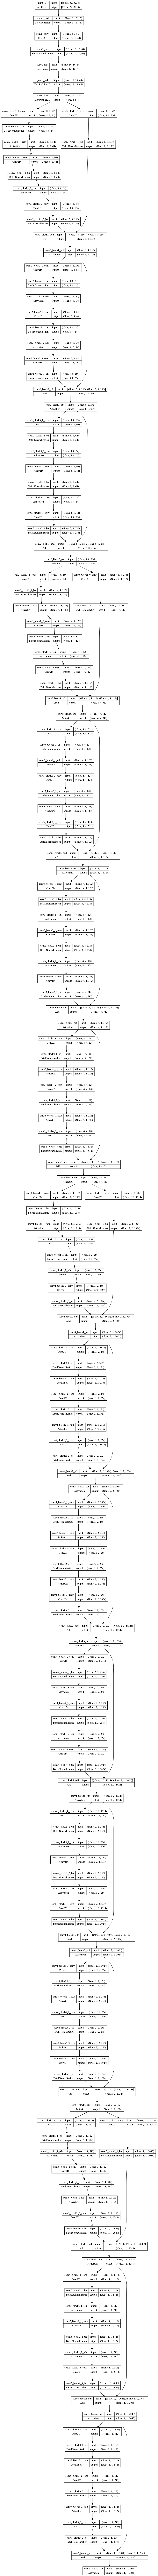

In [5]:
keras.utils.plot_model(modelo_base, show_shapes=True)

In [10]:
modelo_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [5]:
# Congelar las capas del modelo base (ResNet50) para evitar que sus pesos se actualicen durante el entrenamiento inicial
for capa in modelo_base.layers:
    capa.trainable = False

In [13]:
# Definir el modelo final
modelo = Sequential(
    [
        Input(shape=capa_entrada),  # Capa de entrada
        modelo_base,
        GlobalAveragePooling2D(),  # Capa de pooling global (promedio de cada mapa de características)
        Dense(1024, activation='relu'),  # Capa densa
        Dropout(ratio_dropout),  # Capa de dropout
        Dense(num_clases, activation='softmax'),  # Capa de salida
    ]
)

In [14]:
modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,696,138 (98.02 MB)

 Trainable params: 2,108,426 (8.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

MaxPooling se utiliza para reducir la dimensionalidad de las características mediante la selección de los valores máximos en regiones, mientras que GlobalAveragePooling se utiliza para reducir la dimensionalidad al tomar el promedio de todos los valores en cada canal. Ambas técnicas son útiles en diferentes contextos y pueden utilizarse en combinación para extraer características efectivas en redes neuronales convolucionales.

In [15]:
# Compilar el modelo
modelo.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
# Entrenar el modelo
modelo.fit(train_imagenes, train_etiquetas, epochs=10, batch_size=32, validation_data=(test_imagenes, test_etiquetas))


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 207s 126ms/step - accuracy: 0.1573 - loss: 2.3400 - val_accuracy: 0.2212 - val_loss: 2.0237
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 188s 120ms/step - accuracy: 0.2039 - loss: 2.1118 - val_accuracy: 0.2751 - val_loss: 1.9847
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 182s 116ms/step - accuracy: 0.2197 - loss: 2.0705 - val_accuracy: 0.2807 - val_loss: 1.9650
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 194s 124ms/step - accuracy: 0.2223 - loss: 2.0587 - val_accuracy: 0.2914 - val_loss: 1.9288
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 197s 126ms/step - accuracy: 0.2389 - loss: 2.0382 - val_accuracy: 0.3086 - val_loss: 1.9171
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 195s 125ms/step - accuracy: 0.2365 - loss: 2.0264 - val_accuracy: 0.2901 - val_loss: 1.9675
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 189s 121ms/step - accuracy: 0.2403 - loss: 2.0239 - val_accuracy: 0.2987 - val_loss: 1.9384
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 189s 121ms/step - ac

In [17]:
# Evaluar el modelo en el conjunto de test
loss, accuracy = modelo.evaluate(test_imagenes, test_etiquetas)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.3344 - loss: 1.8610
Test Loss: 1.865338921546936
Test Accuracy: 0.33160001039505005


### Reentrenar un modelo previamente entrenado
Podemos aprovechar la estructura de una red previamente entrenada y reajustar sus pesos

In [18]:
# Cargar y preprocesar el conjunto de datos CIFAR-10
(train_imagenes, train_etiquetas), (test_imagenes, test_etiquetas) = cifar10.load_data()

train_imagenes = train_imagenes.astype('float32') / 255.0
test_imagenes = test_imagenes.astype('float32') / 255.0

train_etiquetas = to_categorical(train_etiquetas, 10)
test_etiquetas = to_categorical(test_etiquetas, 10)

In [19]:
# Definir hiperparámetros
num_filtros = 32
tamanio_kernel = 3
tamanio_pool = 2
ratio_dropout = 0.5
num_clases = 10
capa_entrada = (32, 32, 3)

In [20]:
# Crear el modelo ResNet50 sin incluir las capas fully connected y la capa de salida
modelo_base = ResNet50(weights='imagenet', 
                       include_top=False, 
                       input_shape=capa_entrada)

In [22]:
# Definir el modelo final
modelo = Sequential(
    [
        Input(shape=capa_entrada),  # Capa de entrada
        modelo_base,
        GlobalAveragePooling2D(),  # Capa de pooling global
        Dense(1024, activation='relu'),  # Capa densa
        Dropout(ratio_dropout),  # Capa de dropout
        Dense(num_clases, activation='softmax'),  # Capa de salida
    ]
)

In [23]:
# Compilar el modelo
modelo.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Entrenar solo las capas añadidas
modelo.fit(train_imagenes, train_etiquetas, epochs=10, batch_size=32, validation_data=(test_imagenes, test_etiquetas))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1206s 748ms/step - accuracy: 0.3996 - loss: 1.9473 - val_accuracy: 0.3099 - val_loss: 2.3089
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1119s 716ms/step - accuracy: 0.5366 - loss: 1.3461 - val_accuracy: 0.3615 - val_loss: 1.9734
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1160s 742ms/step - accuracy: 0.5912 - loss: 1.1924 - val_accuracy: 0.3734 - val_loss: 2.5851
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1170s 748ms/step - accuracy: 0.5747 - loss: 1.2600 - val_accuracy: 0.5100 - val_loss: 1.4330
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1159s 742ms/step - accuracy: 0.6138 - loss: 1.1218 - val_accuracy: 0.6350 - val_loss: 1.2504
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1153s 737ms/step - accuracy: 0.5862 - loss: 1.2125 - val_accuracy: 0.2883 - val_loss: 3.2566
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1140s 729ms/step - accuracy: 0.6080 - loss: 1.1609 - val_accuracy: 0.6520 - val_loss: 0.9989
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1126s 720ms/s

In [25]:
# Evaluar el modelo en el conjunto de test
perdida, precision = modelo.evaluate(test_imagenes, test_etiquetas)
print(f"Test Loss: {perdida}")
print(f"Test Accuracy: {precision}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.5165 - loss: 3.9419
Test Loss: 3.8917031288146973
Test Accuracy: 0.5094000101089478
